# Week 2: Feature Attribution: Occlusion technique and LIME
Author: Van Bach Nguyen, licensed under the Creative Commons Attribution 3.0 Unported License https://creativecommons.org/licenses/by/3.0/  
Based on: https://github.com/marcotcr/lime

# Table of contents
- [Exercise 1: Occlusion Technique](#Ex1)  
    - [Exercise 1.1](#Ex11)  
    - [Exercise 1.2](#Ex12)  
    - [Exercise 1.3](#Ex13)  
- [Exercise 2: LIME ](#Ex2)  
    - [Exercise 2.1](#Ex21)  
    - [Exercise 2.2](#Ex22)  
    - [Exercise 2.3](#Ex23)  

# Exercise 1: Occlusion Technique <a name="Ex1"></a>
**Description:**  In this exercise, we will practice the occlusion technique on the MNIST dataset. You can either use your own model from the previous week or create a new one by running the code below.

**Goal:** To practice occlusion technique on image data.

**Task:** Occlude a part of an image and check for changes in prediction. Interprete the results.

**Note:** Your results, interpretation, and comments on the results are more important for evaluating the exercises than your code.


#### Load and preprocess data

In [1]:
# Import necessary libraries
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb 
import warnings
warnings.filterwarnings("ignore")

# Load the MNIST dataset from scikit-learn (or you can download it from other sources)
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target
#convert image to rgb (for later purpose)
X_vec = np.stack([gray2rgb(iimg) for iimg in np.array(mnist.data).reshape((-1, 28, 28))],0).astype(np.uint8)
y_vec = mnist.target.astype(np.uint8)
#Split data
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec, test_size=0.2, random_state=42)

#### Create and train model
**Note:** You can replace this part by loading your own model from previous exercise using [*pickle*](https://docs.python.org/3/library/pickle.html)

In [2]:
class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

clf = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('MLP', MLPClassifier(random_state=1, max_iter=300))
    ])

**Comment:** We use neural network(MLPClassifier) as a model.

**Train the model**  
The process would take a while.

In [3]:
clf.fit(X_train,y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x000001C1DFE4C3A0>),
                ('Flatten Image',
                 <__main__.PipeStep object at 0x000001C1DFE4CFD0>),
                ('MLP', MLPClassifier(max_iter=300, random_state=1))])

**Check the accuracy of the model on the test set**

In [4]:
clf.score(X_test, y_test)

0.9770714285714286

**Comment:** good accuracy!

#### Visualize a test point and check the prediction of the model

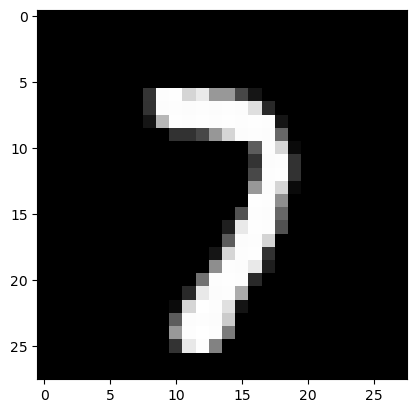

In [28]:
image_index = 8 
plt.imshow(np.array(X_test[3]))


In [29]:
prediction = clf.predict([X_test[3]])
print(f"The prediction is {prediction.item()}")

The prediction is 7


#### Occlude the image
Now, we are experimenting with the occlusion technique by setting the pixel values of one part of the image to 0 (black color).  
Upon observation, it seems that the top-left part of the number might be important for the model to classify whether the image is a 1 or a 7.  
We will now cover that part in the image.  

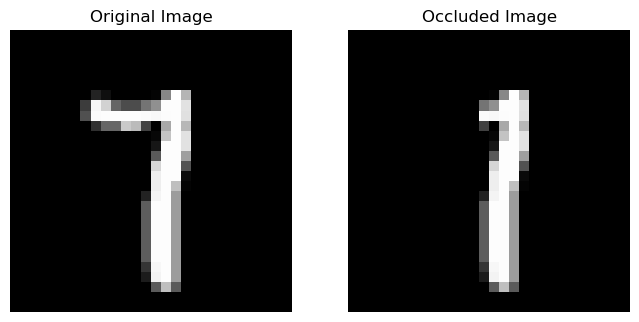

In [33]:
original_image = np.array(X_test[8])

# Define the size of the square for occlusion and its position
occlusion_size = 7  
square_x = 6  
square_y = 6  

# Create an occluded version of the image by replacing the square with zeros (black)
occluded_image = original_image.copy()
occluded_image[square_y:square_y+occlusion_size, square_x:square_x+occlusion_size] = 0

# Display the original and occluded images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(occluded_image, cmap='gray')
plt.title("Occluded Image")
plt.axis('off')

plt.show()

Now that we have the occluded version on the right, let's check the prediction to see if it has changed.

In [34]:
print(f"Prediction of original image: {clf.predict([original_image]).item()}")

Prediction of original image: 7


In [35]:
print(f"Prediction of occluded image: {clf.predict([occluded_image]).item()}")

Prediction of occluded image: 1


In [37]:
print(f"Ground truth: {y_test.iloc[8]}")

Ground truth: 7


**Comment:** As expected, the occluded part of the image is important for the model to differentiate between 1 and 7 as the prediction has been changed for the occlusion version.

## Exercise 1.1 <a name="Ex11"></a>
How about the other parts? Are they important for the model to make predictions?

**Task:** Choose another part to occlude and observe if it changes the model's prediction. In your opinion do the results make sense and why (not)?

In [1]:
#Your own implementation and your interpretation

## Exercise 1.2 <a name="Ex12"></a>
Is the important part of this image also important in another image?  
**Task:** Select another image from the test set with label 7. Occlude the same important part of the number and check for any change in the model's prediction. Interpret the results.

In [2]:
#Your own implementation and your interpretation

## Exercise 1.3 <a name="Ex13"></a>
Practice with different model and different image dataset chosen by your own.  
**Task:** Choose your own image dataset, use your own model, and apply this occlusion technique. Interpret the results.

In [20]:
#Your own implementation and your interpretation

# Exercise 2: LIME <a name="Ex2"></a>

**Task:** Run the example below, you need to install LIME to do it.

**Note:** Your results, interpretation, and comments on the results are more important for evaluating the exercises than your code.

#### Install LIME

In [ ]:
# Run the command below once:
!pip install lime

In [22]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
# Create a LIME Image Explainer with verbose mode turned off
explainer = lime_image.LimeImageExplainer(verbose=False)

# Define a segmentation algorithm for LIME (quickshift) with specific parameters
# https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.quickshift
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=1)

In [29]:
new_index = 2
#Explain a prediction of an image
explanation = explainer.explain_instance(X_test[new_index], 
                                         classifier_fn = clf.predict_proba, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

100%|████████████████████████████████████████| 10000/10000 [00:03<00:00, 2933.08it/s]


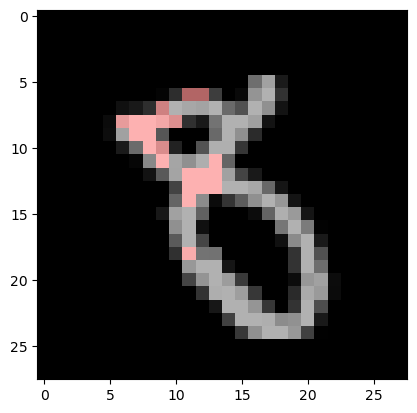

In [30]:
#get the image with the explanation
temp, mask = explanation.get_image_and_mask(y_test.iloc[new_index], num_features=10, hide_rest=False, min_weight = 0.01)
#Visualize it
plt.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'None')

**Comment:** The red areas are the important parts identified through LIME explanation. These areas might be important for the model to differentiate between 6 and 8.

#### Exercise 2.1 <a name="Ex21"></a>
**Task:** Use LIME to explain the prediction for the image in the first exercise and determine whether LIME agrees with our occlusion technique. In other words, check if the important areas highlighted by LIME match the areas we've occluded. What do you conclude?

In [3]:
#Your own implementation and your interpretation

#### Exercise 2.2: <a name="Ex22"></a>
**Task:** Apply LIME to explain the black-box model from the first-week exercise on a tabular dataset. If you don't have that model, simply create and train a new one on one of the tabular datasets in the first week, such as the Diabetes or Cervical Dataset. Interpret the results.  
You can answer questions such as:

- Which features are important for a positive prediction?  
- Which features are important for a negative prediction?  
- Which features are not important?  

In [4]:
#Your own implementation and your interpretation

#### Exercise 2.3 <a name="Ex23"></a>
**Task:** Apply LIME on textual data. You choose your own model and own data. Interpret your results.  
You can answer questions such as:
Which words are important for the model? Do you agree on that?

In [28]:
#Your own implementation and your interpretation